Few-View CT (ADMM w/ Total Variation)
=====================================

This example demonstrates the use of class [admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a few-view CT reconstruction problem with anisotropic total variation (TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x} \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and $\mathbf{x}$ is the desired image.

In [1]:
import numpy as np

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.linop.radon_astra import ParallelBeamProjector
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # Phantom size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # Convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 45  # Number of projections
angles = np.linspace(0, np.pi, n_projection)  # Evenly spaced projection angles
A = ParallelBeamProjector(x_gt.shape, 1, N, angles)  # Radon transform operator
y = A @ x_gt  # Sinogram

Set up ADMM solver object.

In [4]:
λ = 2e-0  # L1 norm regularization parameter
ρ = 5e-0  # ADMM penalty parameter
maxiter = 25  # Number of ADMM iterations
num_inner_iter = 20  # Number of CG iterations per ADMM iteration

g = λ * functional.L1Norm()  # Regularization functionals gi
C = linop.FiniteDifference(input_shape=x_gt.shape)  # Analysis operators Ci

f = loss.SquaredL2Loss(y=y, A=A)

x0 = snp.clip(A.fbp(y), 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": num_inner_iter}),
    verbose=True,
)

Run the solver.

In [5]:
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_reconstruction = snp.clip(solver.x, 0, 1.0)

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  8.908e+03    1.148e+02  3.155e+02


   1  4.650e+03    1.218e+02  2.354e+01


   2  7.130e+03    6.288e+01  2.244e+01


   3  1.323e+04    4.375e+01  2.403e+01


   4  1.878e+04    3.531e+01  2.232e+01


   5  2.315e+04    2.840e+01  2.016e+01


   6  2.618e+04    2.557e+01  1.771e+01


   7  2.828e+04    2.244e+01  1.512e+01


   8  2.962e+04    2.000e+01  1.453e+01


   9  3.036e+04    1.798e+01  1.212e+01


  10  3.080e+04    1.675e+01  1.238e+01


  11  3.110e+04    1.542e+01  1.045e+01


  12  3.127e+04    1.424e+01  1.137e+01


  13  3.139e+04    1.323e+01  9.247e+00


  14  3.144e+04    1.269e+01  9.326e+00


  15  3.153e+04    1.189e+01  8.211e+00


  16  3.152e+04    1.134e+01  8.098e+00


  17  3.160e+04    1.070e+01  7.591e+00


  18  3.159e+04    1.020e+01  7.179e+00


  19  3.167e+04    9.592e+00  8.048e+00


  20  3.162e+04    8.995e+00  6.544e+00


  21  3.168e+04    8.888e+00  6.466e+00


  22  3.168e+04    8.386e+00  6.251e+00


  23  3.172e+04    8.067e+00  5.815e+00


  24  3.172e+04    7.819e+00  5.439e+00


Show the recovered image.

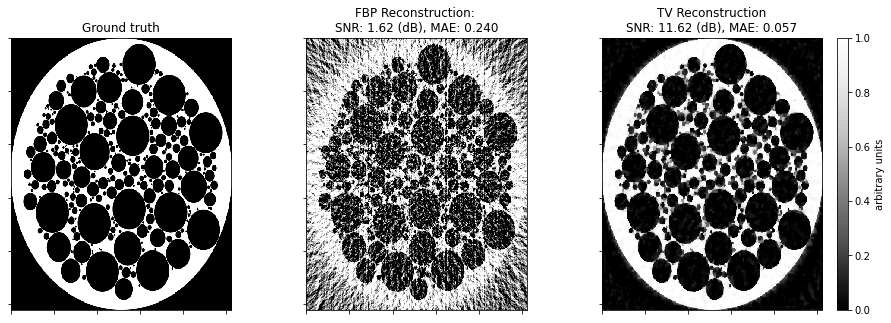

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    x0,
    title="FBP Reconstruction: \nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x0), metric.mae(x_gt, x0)),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    x_reconstruction,
    title="TV Reconstruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x_reconstruction), metric.mae(x_gt, x_reconstruction)),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics.

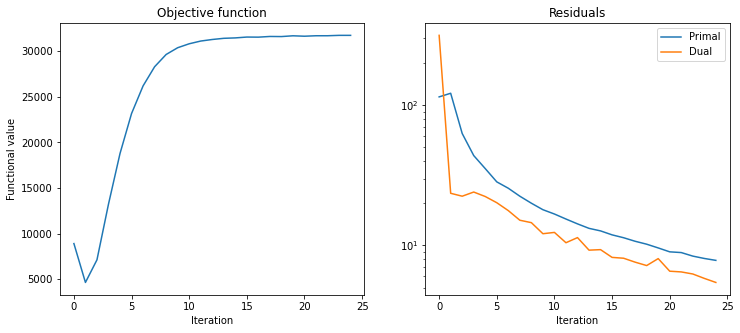

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()